In [5]:
# Import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, Bidirectional, Input, LSTM, RepeatVector, Dropout
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Model

In [7]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize the data to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Print the shape of the dataset
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")


Training data shape: (50000, 32, 32, 3), Test data shape: (10000, 32, 32, 3)


Blurred and noisy training data shape: (50000, 32, 32, 3)
Blurred and noisy test data shape: (10000, 32, 32, 3)


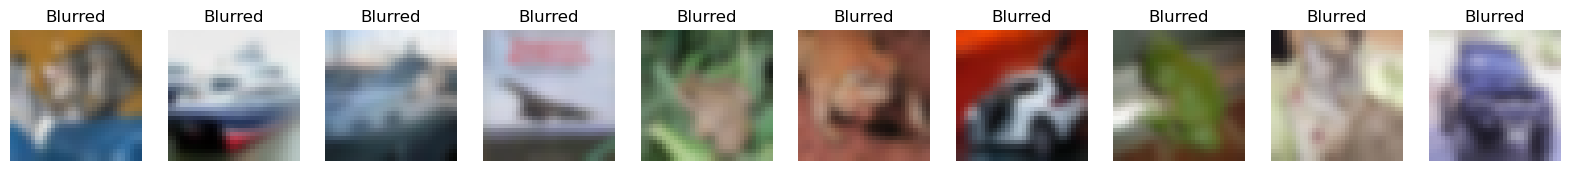

In [9]:
# Function to apply Gaussian blur to images
def apply_gaussian_blur(images):
    blurred_images = []
    for img in images:
        blurred_img = cv2.GaussianBlur(img, (5, 5), 0)  # Apply Gaussian blur
        blurred_images.append(blurred_img)
    return np.array(blurred_images)

# Apply Gaussian blur to create input data for training
X_train_blurred = apply_gaussian_blur(X_train)
X_test_blurred = apply_gaussian_blur(X_test)

# Function to add random noise to images
def add_noise(images):
    noise_factor = 0.1
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)  # Ensure the values are in the correct range [0, 1]
    return noisy_images

# Add noise to the blurred images
X_train_noisy = add_noise(X_train_blurred)
X_test_noisy = add_noise(X_test_blurred)

# Verify the shapes
print(f"Blurred and noisy training data shape: {X_train_noisy.shape}")
print(f"Blurred and noisy test data shape: {X_test_noisy.shape}")

# Display original and blurred images
n = 10  # Number of images to display
plt.figure(figsize=(20, 8))
for i in range(n):
    # Display blurred
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_blurred[i])
    plt.title("Blurred")
    plt.axis("off")
plt.show()

In [11]:
# Reshape the data to shorter sequences for faster training
X_train_seq = X_train.reshape((X_train.shape[0], 32, 32 * 3))  # Each sequence has 32 time steps, each with 96 features
X_test_seq = X_test.reshape((X_test.shape[0], 32, 32 * 3))     # Same for test data

# Reshape blurred data
X_train_blurred_seq = X_train_blurred.reshape((X_train_blurred.shape[0], 32, 32 * 3))
X_test_blurred_seq = X_test_blurred.reshape((X_test_blurred.shape[0], 32, 32 * 3))

print(f"Shape after reshaping - Train: {X_train_seq.shape}, Blurred: {X_train_blurred_seq.shape}")


Shape after reshaping - Train: (50000, 32, 96), Blurred: (50000, 32, 96)


In [33]:
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler()
X_train_seq = scaler.fit_transform(X_train_seq.reshape(-1, 32 * 96)).reshape(-1, 32, 96)
X_test_seq = scaler.transform(X_test_seq.reshape(-1, 32 * 96)).reshape(-1, 32, 96)
X_train_blurred_seq = scaler.transform(X_train_blurred_seq.reshape(-1, 32 * 96)).reshape(-1, 32, 96)
X_test_blurred_seq = scaler.transform(X_test_blurred_seq.reshape(-1, 32 * 96)).reshape(-1, 32, 96)

In [72]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model

def build_lstm_autoencoder():
    # Encoder
    encoder_input = Input(shape=(32, 96))  # 32 time steps, 96 features per step
    encoded = LSTM(256, activation='relu', return_sequences=True)(encoder_input)  # Increase units to 256
    encoded = LSTM(128, activation='relu', return_sequences=False)(encoded)  # Add another LSTM layer
    
    # Decoder
    decoded = RepeatVector(32)(encoded)  # Repeat for 32 time steps
    decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(256, activation='relu', return_sequences=True)(decoded)  # Add another LSTM layer
    decoded = TimeDistributed(Dense(96, activation='tanh'))(decoded)  # Use 'tanh' activation
    
    # Autoencoder model
    autoencoder = Model(encoder_input, decoded)
    return autoencoder

# Define the combined loss function
def combined_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return mse_loss + ssim_loss

# Build and compile the LSTM autoencoder
lstm_autoencoder = build_lstm_autoencoder()
lstm_autoencoder.compile(optimizer='adam', loss=combined_loss)  # Lower learning rate

# Summarize the model
lstm_autoencoder.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 32, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 32, 256)        │       361,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 32, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 32, 96)         │        24,672 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,109,088 (4.23 MB)

 Trainable params: 1,109,088 (4.23 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history_lstm = lstm_autoencoder.fit(X_train_blurred_seq, X_train_seq,
                                    epochs=100,
                                    batch_size=64,
                                    validation_data=(X_test_blurred_seq, X_test_seq))


Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 597s 588ms/step - loss: 0.9197 - val_loss: 0.6873
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 430s 548ms/step - loss: 0.7172 - val_loss: 0.6959
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 437s 559ms/step - loss: 0.6779 - val_loss: 0.6298
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 453s 579ms/step - loss: 0.5881 - val_loss: 0.4693
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 447s 572ms/step - loss: 0.4475 - val_loss: 0.3969
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 438s 560ms/step - loss: 0.3852 - val_loss: 0.3545
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 440s 562ms/step - loss: 0.3440 - val_loss: 0.3234
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 444s 568ms/step - loss: 0.3157 - val_loss: 0.3061
Epoch 9/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 494s 557ms/step - loss: 0.2986 - val_loss: 0.2903
Epoch 10/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 439s 561ms/step - loss: 0.2851 - val_loss: 0.2778
Epoch 11/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 433s 554ms/step - loss: 0.2723 - val_loss: 0.26

313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 148ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


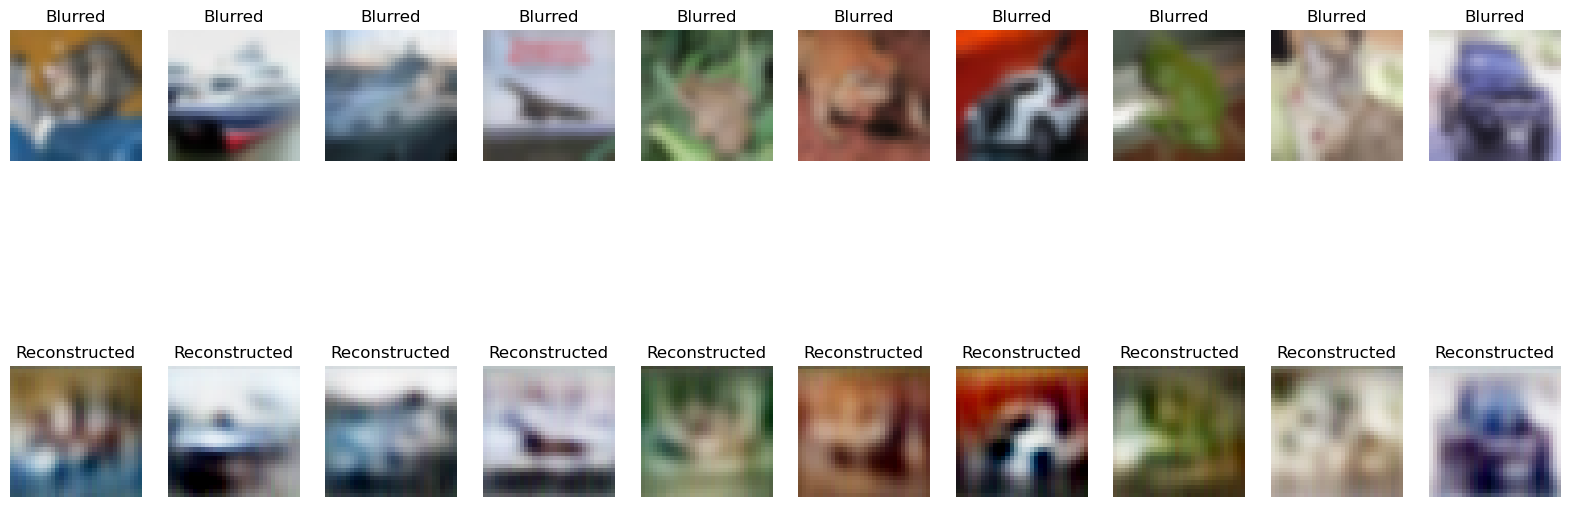

In [54]:
import matplotlib.pyplot as plt

# Generate predictions using the LSTM autoencoder
X_test_lstm_pred = lstm_autoencoder.predict(X_test_blurred_seq)

# Assuming n is the number of images you want to display
n = 10

# Reshape the predictions back to the original image shape
X_test_lstm_pred = X_test_lstm_pred.reshape((X_test_lstm_pred.shape[0], 32, 32, 3))

# Display blurred and LSTM reconstructed images
plt.figure(figsize=(20, 8))
for i in range(n):
    # Display blurred
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_blurred[i])
    plt.title("Blurred")
    plt.axis("off")
    
    # Display reconstructed by LSTM autoencoder
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_test_lstm_pred[i])
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()
